In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plot
import seaborn
import re

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.stats as stats

from tensorflow.keras.layers import Embedding
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from tqdm import tqdm


In [3]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

In [4]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [5]:
%%time 
glove_6B_300d_embeddings = load_embeddings('data/embeddings/glove/glove.6B.300d.txt')
glove_6B_300d_embeddings.shape

CPU times: user 21.1 s, sys: 1.09 s, total: 22.2 s
Wall time: 22.3 s


(400000, 300)

In [6]:
pos_words = load_lexicon('data/lexicons/hu_liu_2004/opinion-lexicon-English/positive-words.txt')
neg_words = load_lexicon('data/lexicons/hu_liu_2004/opinion-lexicon-English/negative-words.txt')
print("Positive Words: ", len(pos_words), "Negative Words: ", len(neg_words))

Positive Words:  2006 Negative Words:  4783


In [ ]:
type(pos_words)

In [ ]:
pos_words_common = list(set(pos_words) & set(glove_6B_300d_embeddings.index)) 
neg_words_common = list(set(neg_words) & set(glove_6B_300d_embeddings.index)) 
pos_vectors = glove_6B_300d_embeddings.loc[pos_words_common]
neg_vectors = glove_6B_300d_embeddings.loc[neg_words_common]
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [7]:
from sklearn.datasets import fetch_20newsgroups
bunch = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

In [9]:
len(bunch.data)

11314

In [ ]:
bunch.target

In [11]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 1000 # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(bunch.data)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(bunch.data)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(bunch.target)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 134142 unique tokens. Distilled to 134142 top words.
Shape of data tensor: (11314, 1000)
Shape of label tensor: (11314, 20)
134142
CPU times: user 3.41 s, sys: 20.1 ms, total: 3.43 s
Wall time: 3.44 s


In [12]:
len(X)

11314

In [16]:
words = list(pos_words + neg_words)
targets = [1 for entry in pos_words] + [-1 for entry in neg_words]

In [17]:
len(words)

6789

In [18]:
%%time
EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('data/embeddings/glove/glove.6B.300d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.
CPU times: user 15.1 s, sys: 589 ms, total: 15.7 s
Wall time: 15.6 s


In [19]:
NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 1000 # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(words)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(words)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)
# y_ohe = keras.utils.to_categorical(targets)


Found 6788 unique tokens. Distilled to 6788 top words.


In [21]:
len(y_ohe)

6789

In [22]:
# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Embedding Shape: (6789, 300) 
 Total words found: 6316 
 Percentage: 93.03284725290912


In [23]:
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding
NUM_CLASSES= 2
EMBED_SIZE = 300 
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = Dropout(0.05)(x)
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.15)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 35 elements long
x = MaxPooling1D(35)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 300)         2036700   
                                                                 
 conv1d_9 (Conv1D)           (None, 996, 128)          192128    
                                                                 
 dropout_12 (Dropout)        (None, 996, 128)          0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 199, 128)          0         
                                                           

In [ ]:
X.shape

In [ ]:
y_ohe.shape

In [47]:
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, 
                 y_ohe, 
                 test_size=0.2, 
                 random_state=42)

In [45]:
histories = []

In [50]:
tmp = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=2, batch_size=128)
histories.append(tmp)

Epoch 1/2
43/43 [==============================] - 17s 372ms/step - loss: 0.0643 - acc: 0.9766 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 2/2
43/43 [==============================] - 16s 371ms/step - loss: 6.4611e-05 - acc: 1.0000 - val_loss: 4.7607e-04 - val_acc: 1.0000


In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
STARTING_TEST = {
    "Christianity": [
        "I love Jesus", "I enjoy Gospel", "We use Baptism", "This is Catholicism", "The God is the creator",
        "I am an Apostle",  "Gospel was spread by the Disciple", "The Salvation is by grace", "Christian is so popular", "Faith is the invisible power",
        "This the one of the best Evangelical church", "Christendom is the state of being a christian", "I must persist with Prayer", "I am an Apostolic", "I belong to the Lord", "I would be a Preacher", "This is the final Atonement", 
        "I wear my Crucifix", "This is the church of Anglican", "It was on the old Covenant", "We believe in Resurrection", "The Easter is christian holiday", "Take the Communion as a remembrance of me", "We will go to Heaven"
    ],
    "Judaism": [
        "I am Jewish", " I enjoyed Passover", "Shalom, how are you?", "I read the Torah", "Messiah is the savior", "I am a Gentile", "I am a Ashkenazi", "A Cantor sings", "I was granted Eruv",
        "Tabernacle is the tent of the congregation", "I only eat Kosher", "I lit the Menorah", "Pentecost is a feast", "Pharisee is a movement", "I wear a Skullcap", "Sukkot is a holiday", "Purim is a festival",
        "Living in the Diaspora", "Mohel is a rabbi", "Matzah is an unleavened flatbread", "I visited my Shul yesterday", "I wore my Tzitzit", "I speak Hebrew",
        "Shabbat is celebrated on saturday", "I celebrated Hanukkah", "I went to the Synagogue", "I read the Talmud", "We hosted a Mitzvah", "Zion is a nationalist movement"
    ],
    "Buddhism": [
        "I follow Buddha", "Chan is a way of living", "Danais cultivated", "Karma driven by intention", "I am a student of Mahayana", "I like that Koan", "Sitting Zen",
        "I enjoy Meditation", "I am a Monk", "Nirvana is my goal", "Pali canon is the standard collection", "Qigong leads to buddhahood", "Sangha means community",
        "Sanskrit main language of buddhist", "I follow the Theravada traditions","My experience with Vipassana was enlightening", "Yoga is good for peace of mind",
        "Bodhisattva", "Vipassana", "Lama is a spiritual teacher", "Stupa is a sacred monument", "Sutra is a sacred text", "Dhyana is a deep profound meditation", "Samsara is a process of continuous wandering through existence"
    ],
    "Islam": [
        "Allah is gracious", "My name is Amir", "God is Alim", "Ramadan Mubarak", "I am Muslim", "Salaam, how are you?", "We went to the Mosque",
        "I need to ask for a Fatwa", "Muhammad is the prophet", "Sharia is a code", "I visited Mecca", "Jihad literally means striving", "I performed Hajj last year", "I enjoy Fasting", "My friend wears the Hijab",
        "Takbir is the act of calling to prayer", "Barakah is a blessing", "I only eat Halal", "God is gracious", "Salat is a must", "I paid my Zakat", "I took my Shahada last year ", "I visited madina"
        "Making one is Tawhid", "I read an interesting Hadith", "I asked the Imam a questions", "I am Shia", "I am Sunnah", "I ask for a Tafsir", "I read the Quran"
    ]
}


In [51]:
islam = STARTING_TEST["Islam"]
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(islam)
sequences = tokenizer.texts_to_sequences(islam)
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

islam_X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

Found 76 unique tokens. Distilled to 76 top words.


In [125]:
Buddhism = STARTING_TEST["Buddhism"]
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(Buddhism)
sequences = tokenizer.texts_to_sequences(Buddhism)
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

Buddhism_X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

Found 75 unique tokens. Distilled to 75 top words.


In [ ]:
christ = STARTING_TEST["Christianity"]
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(christ)
sequences = tokenizer.texts_to_sequences(christ)
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

christ_X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

In [118]:
Judaism = STARTING_TEST["Judaism"]
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(Judaism)
sequences = tokenizer.texts_to_sequences(Judaism)
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

Judaism_X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

Found 73 unique tokens. Distilled to 73 top words.


In [56]:
result_islam = model.predict(islam_X)

1/1 [==============================] - 0s 60ms/step


In [64]:
result_christ = model.predict(christ_X)

1/1 [==============================] - 0s 46ms/step


In [59]:
import math


In [61]:
sent = []
for a in result_islam:
    sent.append(math.log(a[0]) - math.log(a[1]))

In [65]:
sent_c = []
for a in result_christ:
    sent_c.append(math.log(a[0]) - math.log(a[1]))

In [103]:
def hehe(res):
    return math.log(res[0]) - math.log(res[1])

In [109]:
model.predict(np.expand_dims(islam_X[0], axis=0), verbose=0)[0]

7.156163e-06

In [126]:
def sentiment_table():
    frames = []
    for sent in islam_X:
        sentiment = {}
        sentiment['sentiment'] = hehe(model.predict(np.expand_dims(sent, axis=0), verbose=0)[0])
        sentiment['group'] = 'islam'
        frames.append(pd.DataFrame([sentiment]))
        
    for sent in christ_X:
        sentiment = {}
        sentiment['sentiment'] = hehe(model.predict(np.expand_dims(sent, axis=0), verbose=0)[0])
        sentiment['group'] = 'christ'
        frames.append(pd.DataFrame([sentiment]))
        
    for sent in Judaism_X:
        sentiment = {}
        sentiment['sentiment'] = hehe(model.predict(np.expand_dims(sent, axis=0), verbose=0)[0])
        sentiment['group'] = 'Judaism'
        frames.append(pd.DataFrame([sentiment]))
        
    for sent in Buddhism_X:
        sentiment = {}
        sentiment['sentiment'] = hehe(model.predict(np.expand_dims(sent, axis=0), verbose=0)[0])
        sentiment['group'] = 'Buddhism'
        frames.append(pd.DataFrame([sentiment]))
    return pd.concat(frames)

In [127]:
result = sentiment_table()

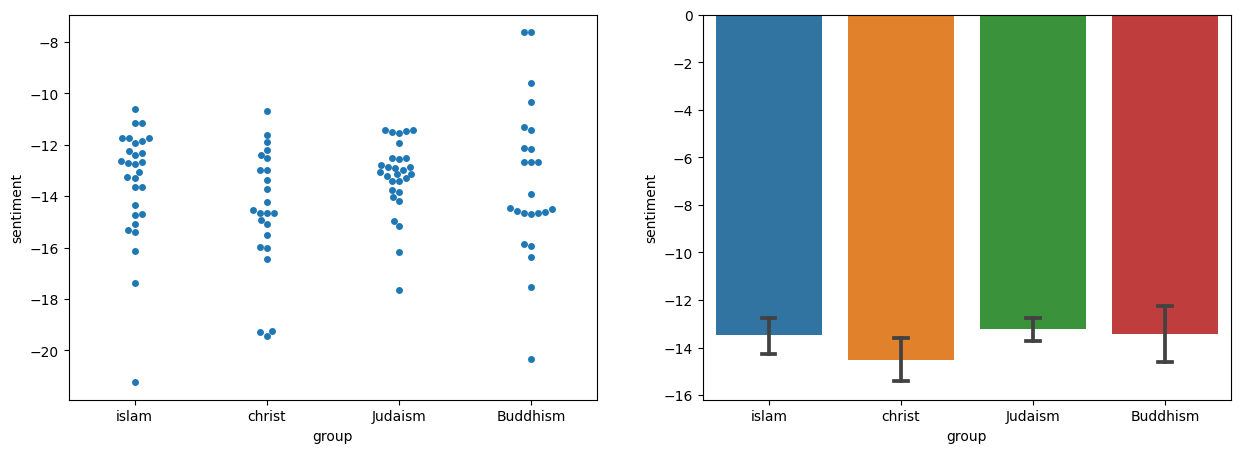

In [128]:
matplotlib.pyplot.figure(figsize=(15,5))
matplotlib.pyplot.subplot(121)
plot = seaborn.swarmplot(x='group', y='sentiment', data=result)
# plot.set_ylim([-10, 10])
matplotlib.pyplot.subplot(122)
plot = seaborn.barplot(x='group', y='sentiment', data=result, capsize=.1)